<a href="https://colab.research.google.com/github/abeersethia/CCM_EEG/blob/main/Verifying_Taken's_Theorem_with_Forecasting_Skill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this experiment, I empirically test Takens' Theorem, which states that for a system with intrinsic dimension d, a time-delay embedding of size T≥2d+1 is sufficient to reconstruct its attractor. For the Lorenz system with d≈3, this gives T=7 as the theoretical minimum.

To validate this, I use two complementary metrics:
1. False Nearest Neighbors (FNN %) to evaluate the geometric fidelity of the embedding.
2. Forecasting Skill (R² score) to evaluate its predictive usefulness.

I generate 10,000 steps of the Lorenz attractor using Euler integration, and analyze only the x-coordinate. Although the system is 3D, Takens' theorem allows reconstruction from a scalar observable like x(t).

For each embedding dimension
T, I:

Build a Hankel (delay) matrix of shape (N−T)×T, with rows of the form [x(t),x(t+1),...,x(t+T−1)].

Calculate FNN % by:

Finding
K-nearest neighbors in T-dim space,

Extending to T+1 dimensions,

Flagging neighbors as false if:

The relative distance increases
>
𝑅
tol
=
10
>R
tol
​
 =10

Or the absolute change
>
𝐴
tol
=
2
×
std
(
𝑥
)
>A
tol
​
 =2×std(x)

Train a Ridge regression model to predict
x(t+T) from the T-length window, and compute the R² score on a held-out test set.

These two measures capture different properties:

FNN % tells us if the attractor is geometrically unfolded (based on topology).

R² tells us if the embedding captures enough dynamics to predict the future (based on function).

I evaluate both across
T=2 to
19, and plot the results with:

FNN % on the left Y-axis

R² score on the right Y-axis

A vertical reference line at
T=7, the Takens threshold

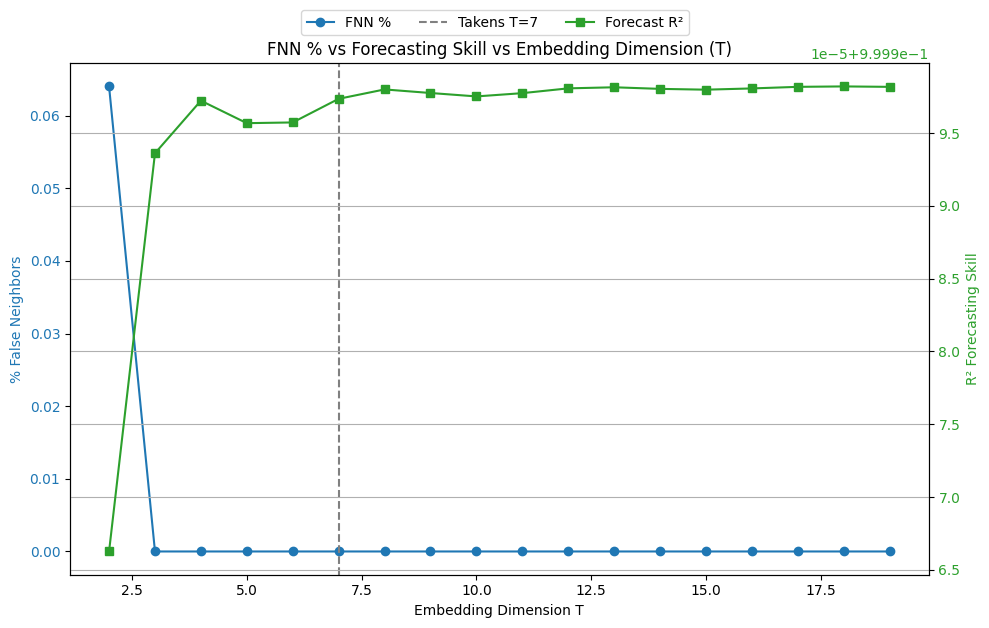

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Generate Lorenz attractor
def generate_lorenz(n_steps=10000, dt=0.01, sigma=10, rho=28, beta=8/3):
    traj = np.zeros((n_steps, 3))
    traj[0] = [1, 1, 1]
    for i in range(1, n_steps):
        x, y, z = traj[i - 1]
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        traj[i] = traj[i - 1] + dt * np.array([dx, dy, dz])
    return traj

# FNN Calculation (1D embedding)
def calculate_fnn(signal, T, K=5, R_tol=10.0, A_tol=1.0):
    N = len(signal)
    embedded = np.array([signal[i:i+T] for i in range(N - T - 1)])
    embedded_next = np.array([signal[i+T] for i in range(N - T - 1)])

    nbrs = NearestNeighbors(n_neighbors=K+1).fit(embedded)
    dists, indices = nbrs.kneighbors(embedded)

    false_count = 0
    for i in range(len(embedded)):
        for k in range(1, K+1):
            j = indices[i, k]
            dist_T = np.linalg.norm(embedded[i] - embedded[j])
            dist_T1 = abs(embedded_next[i] - embedded_next[j])
            if dist_T == 0:
                continue
            R = dist_T1 / dist_T
            A = dist_T1 / np.std(signal)
            if R > R_tol or A > A_tol:
                false_count += 1
    total = len(embedded) * K
    return 100 * false_count / total  # FNN percentage

# Forecasting skill
def forecast_r2(signal, T):
    X = np.array([signal[i:i+T] for i in range(len(signal) - T)])
    y = np.array(signal[T:])
    split = int(0.8 * len(X))
    model = Ridge()
    model.fit(X[:split], y[:split])
    pred = model.predict(X[split:])
    return r2_score(y[split:], pred)

# Run for multiple T values
signal = generate_lorenz()[:, 0]  # Use x-dimension
T_values = range(2, 20)
fnn_values = []
r2_scores = []

for T in T_values:
    fnn = calculate_fnn(signal, T)
    r2 = forecast_r2(signal, T)
    fnn_values.append(fnn)
    r2_scores.append(r2)

# Plot results
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Embedding Dimension T')
ax1.set_ylabel('% False Neighbors', color=color1)
ax1.plot(T_values, fnn_values, marker='o', color=color1, label='FNN %')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axvline(x=7, linestyle='--', color='gray', label='Takens T=7')

# Second Y-axis
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('R² Forecasting Skill', color=color2)
ax2.plot(T_values, r2_scores, marker='s', color=color2, label='Forecast R²')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.title("FNN % vs Forecasting Skill vs Embedding Dimension (T)")
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
plt.grid(True)
plt.show()


## Observation
### Discrepancy Between FNN Drop and Takens’ Theoretical Minimum
While verifying Takens' theorem using forecasting skill and false nearest neighbor (FNN) analysis on the Lorenz attractor, we observed that:
1. The FNN percentage dropped significantly around T=3, well below the theoretical minimum T=7 suggested by Takens’ theorem for a 3D system.
2. The forecasting skill (R² score) also saturated around this lower
T, indicating that the system's short-term dynamics were effectively captured.

## Interpretation

1. Takens' bound (T ≥ 2d + 1) is a sufficient condition for topological reconstruction, not a necessary one. Practical systems may show good embeddings at lower
T.
2. FNN measures local geometry, and may indicate sufficient neighborhood preservation earlier than required for full global unfolding.

3. Forecasting skill reflects functional predictability rather than full attractor reconstruction, and may also peak earlier.

## Conclusion
The early drop in FNN % and forecasting saturation around
T=3 do not contradict Takens’ theorem.
Instead, they highlight that practical embedding dimensions may be smaller than theoretical bounds, especially when: